In [1]:
import os
from PIL import Image
import math
import glob
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import fire

In [2]:
from concurrent.futures import ProcessPoolExecutor

In [3]:
import bcolz
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pickle

In [4]:
def resize_img(fname, targ, path, new_path):
    dest = os.path.join(path,new_path,str(targ),fname)
    if os.path.exists(dest): return
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    r,c = im.size
    if r < targ and c < targ: return im.save(dest) # only downsize to target, no upsize
    ratio = targ/min(r,c)
    sz = (scale_to(r, ratio, targ), scale_to(c, ratio, targ))
    os.makedirs(os.path.split(dest)[0], exist_ok=True)
    im.resize(sz, Image.LINEAR).save(dest)

def resize_imgs(fnames, targ, path, new_path):
    if not os.path.exists(os.path.join(path,new_path,str(targ),fnames[0])):
        with ThreadPoolExecutor() as e:
            ims = e.map(lambda x: resize_img(x, targ, path, new_path), fnames)
            for x in tqdm(ims, total=len(fnames), leave=False): pass
    return os.path.join(path,new_path,str(targ))

def read_dir(path, folder):
    full_path = os.path.join(path, folder)
    fnames = glob(f"{full_path}/*.*")
    if any(fnames):
        return [os.path.relpath(f,path) for f in fnames]
    else:
        raise FileNotFoundError("{} folder doesn't exist or is empty".format(folder))

def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints','.DS_Store'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

def scale_to(x, ratio, targ): return max(math.floor(x*ratio), targ)

def resize(targ, source_dir=None, resize_folder='resize'):
    if source_dir is None:
        source_dir = Path.home()/'data/imagenet'
    val_filenames, val_labels, val_all_labels = read_dirs(source_dir, 'validation'); 
    print(f'Found {len(val_filenames)} validation images')

    train_filenames, train_labels, train_all_labels = read_dirs(source_dir, 'train'); len(train_filenames)
    print(f'Found {len(train_filenames)} training images')

    resize_imgs(train_filenames, targ, source_dir, resize_folder)
    resize_imgs(val_filenames, targ, source_dir, resize_folder)

In [5]:
source_dir = Path.home()/'data/imagenet'

In [6]:
train_filenames, train_labels, train_all_labels = read_dirs(source_dir, 'train'); len(train_filenames)

1281167

In [7]:
fname = source_dir/train_filenames[0]

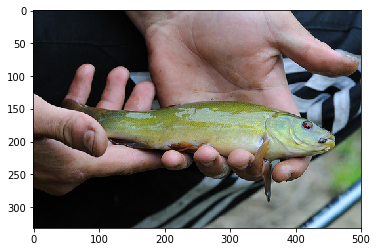

In [8]:
plt.imshow(plt.imread(fname))

In [9]:
def load_array(fname): 
    return bcolz.open(fname)[:]

In [10]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [11]:
import numpy as np

In [12]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [13]:
def norm(img):
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255], dtype=np.float32)
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255], dtype=np.float32)
    return (img-mean)/std

In [14]:
def file_to_numpy(fname):
    pil_img = pil_loader(fname)
    return np.asarray(pil_img, dtype=np.uint8)

In [15]:
def get_bcolz_path(fname):
    return str(fname).replace('imagenet/', 'bcolz/imagenet/').replace(fname.suffix, '.bc')

In [16]:
get_bcolz_path(fname)

'/home/paperspace/data/bcolz/imagenet/train/n01440764/n01440764_11350.bc'

In [17]:
def channel_first(img_arr):
    return np.rollaxis(img_arr, 2)

In [18]:
fname.parent

PosixPath('/home/paperspace/data/imagenet/train/n01440764')

In [27]:
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
# IMG_EXTENSIONS = ['.jpg', '.jpeg']

In [28]:
def file_to_bcolz(fname):
    fname = source_dir/fname
    if fname.suffix.lower() not in IMG_EXTENSIONS: 
        print('Skipping:', fname); 
        return fname
    new_path = get_bcolz_path(fname)
    if os.path.exists(new_path): return
    np_arr = file_to_numpy(fname)
    norm_arr = norm(np_arr)
    nchw_arr = channel_first(norm_arr)
    new_path = get_bcolz_path(fname)
    os.makedirs(Path(new_path).parent, exist_ok=True)
    save_array(new_path, nchw_arr)
    return nchw_arr

In [29]:
def save_files(fnames):
    with ThreadPoolExecutor() as e:
        ims = e.map(file_to_bcolz, fnames)
        for x in tqdm(ims, total=len(fnames), leave=False): pass

In [ ]:
for i,fname in enumerate(train_filenames[630:640]):
    print(i, fname)
    file_to_bcolz(fname)

In [ ]:
save_files(train_filenames)

  6%|▌         | 73876/1281167 [11:56<3:15:05, 103.14it/s]

In [ ]:
for fname in train_filenames:
    file_to_bcolz(fname)

In [ ]:
idx = 1

In [ ]:
fname = Path(train_dataset.imgs[idx][0]); fname

In [ ]:
barr = file_to_bcolz(fname)

In [ ]:
barr.dtype

### Get AR

In [ ]:
traindir = source_dir/'train'
valdir = source_dir/'validation'

In [ ]:

import os.path
def sort_ar(valdir):
    idx2ar_file = valdir+'/../sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Creating AR indexes. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir)
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    print('Done')
    return sorted_idxar

In [ ]:

trn_dataset = datasets.ImageFolder(traindir)
sizes = [img[0].size for img in tqdm(trn_dataset, total=len(trn_dataset))]

In [ ]:

val_dataset = datasets.ImageFolder(valdir)
sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]

## Double check with pytorch dataloader

In [ ]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tensor_tfm = [transforms.ToTensor(), normalize]

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose(tensor_tfm))

In [ ]:
train_dataset.imgs[idx]

In [ ]:
train_dataset[idx][0]

In [ ]:
def get_loaders(traindir, valdir):

    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(int(args.sz*1.14)),
            transforms.CenterCrop(args.sz),
        ] + tensor_tfm)),
        batch_size=args.batch_size*2, shuffle=False,
        num_workers=args.workers, pin_memory=False)

    return train_loader,val_loader,train_sampler

In [ ]:
trn_dl, val_dl, trn_smp = get_loaders(traindir, valdir)